In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:

#Load shape and population data from the swiss federal office of topography
#Adress:
#https://shop.swisstopo.admin.ch/en/products/landscape/boundaries3D
#shp_path = 'swissTLMRegio_LANDESGEBIET_LV03.shp'
shp_path = 'swiss_shp/swissTLMRegio_LANDESGEBIET_LV03.shp'
sf = shp.Reader(shp_path, encoding='windows-1252')

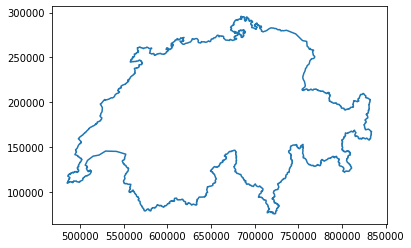

In [14]:
#Print country shape

shape=sf.shapeRecords()[7]
x = [i[0] for i in shape.shape.points[:]]
y = [i[1] for i in shape.shape.points[:]]
plt.plot(x[0:-175], y[0:-175])

In [18]:
#Load data with region attributes and put it into a dataframe
shp_path = 'swiss_shp/swissTLMRegio_HOHEITSGEBIET_LV03.shp'
sf = shp.Reader(shp_path, encoding='windows-1252')
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]
df = pd.DataFrame(columns=fields, data=records)
df = df.assign(coords=shps)
df.head(5)

,OBJECTID,UUID,DATUM_AEND,DATUM_ERST,HERKUNFT,HERKUNFT_J,OBJEKTART,BFS_NUMMER,BEZIRKSNUM,KANTONSNUM,NAME,GEM_TEIL,GEM_FLAECH,SEE_FLAECH,ICC,SHN,EINWOHNERZ,coords
0,8907,80BDC838-B025-4860-B319-3C87EF5B26C2,2019-09-24,2016-01-18,EBM,2018,Gemeindegebiet,0,AT70200,AT70000,Sölden,0,-29999.0,-29998.0,AT,AT70220,3124,"[(883434.7562500015, 208358.54250000045), (883..."
1,8908,FE2E874F-B9B8-4714-96CF-5F8AA5DF451E,2019-12-04,2009-03-25,TLM,2019,Gemeindegebiet,3762,CH18430000,CH18000000,Scuol,0,43861.0,-29998.0,CH,CH18433762,4638,"[(812980.4475000016, 194958.07375000045), (813..."
2,8909,3FA8610C-EB98-4DBA-8A62-D22D739D6032,2019-12-04,2011-04-12,TLM,2019,Gemeindegebiet,1631,N/A,CH08000000,Glarus Süd,0,43003.0,-29998.0,CH,CH08001631,9575,"[(730976.0, 192852.0), (730702.0, 192726.0), (..."
3,8910,9CCECBE8-D621-4DF5-BB7B-409F9BF06A46,2019-12-04,2009-03-25,TLM,2019,Gemeindegebiet,3746,CH18430000,CH18000000,Zernez,0,34404.0,-29998.0,CH,CH18433746,1540,"[(802701.8987499997, 192061.9750000015), (8027..."
4,8911,43CB4FD5-59A4-469E-824D-4E6D9A9172FE,2019-12-04,2016-01-21,TLM,2019,Gemeindegebiet,3543,CH18410000,CH18000000,Surses,0,32377.0,-29998.0,CH,CH18413543,2356,"[(775675.0, 153305.0), (775346.0, 152390.0), (..."


In [19]:
#Create pandas dataframe with lakes coordinates
lac_data=[]
for i in range(0, len(df)):
    #print(df.loc[i, 'GEM_TEIL']==str(0))
    #if df.loc[i, 'GEM_TEIL']==str(1):
    if int(df.loc[i, 'EINWOHNERZ'])<0:
        #print(df.loc[i, 'NAME'])
        #print(df.loc[i, 'EINWOHNERZ'])
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']])
lac_data_df=pd.DataFrame(lac_data, columns=['name', 'coordinates'])

In [20]:
#Create pandas dataframe with region coordinates and population

commune_data=[]

for i in range(0, len(df)):
    if int(df.loc[i, 'EINWOHNERZ'])>0 and df.loc[i, 'ICC']=='CH': #exclude data on lakes and outside of the country
        pop_density=round(int(df.loc[i, 'EINWOHNERZ'])/int(df.iloc[i, 12]), 4)
        if pop_density<0:
            pop_density=0
        commune_data.append([df.loc[i, 'NAME'], df.loc[i, 'EINWOHNERZ'], df.iloc[i, 12], str(pop_density), df.loc[i, 'coords']])
        
    population_data=pd.DataFrame(commune_data, columns=['name', 'pop', 'surface', 'density', 'coordinates'])
population_data.head()

,name,pop,surface,density,coordinates
0,Scuol,4638,43861.0,0.1057,"[(812980.4475000016, 194958.07375000045), (813..."
1,Glarus Süd,9575,43003.0,0.2227,"[(730976.0, 192852.0), (730702.0, 192726.0), (..."
2,Zernez,1540,34404.0,0.0448,"[(802701.8987499997, 192061.9750000015), (8027..."
3,Surses,2356,32377.0,0.0728,"[(775675.0, 153305.0), (775346.0, 152390.0), (..."
4,Bagnes,8073,28410.0,0.2842,"[(599458.0, 93275.0), (599363.0, 92955.0), (59..."


(441150.45437499846, 916611.883125, 12802.695187500678, 347356.8560624989)

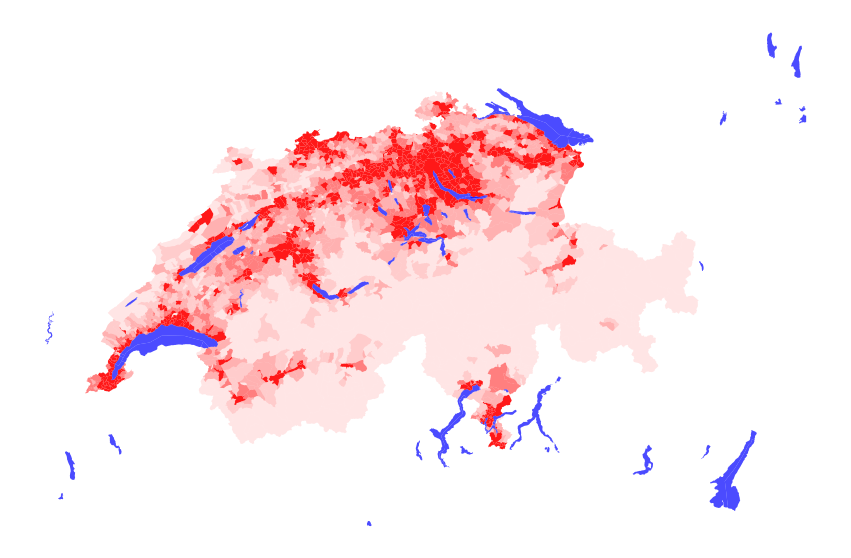

In [21]:
#Plot results on a map

plt.figure(figsize = (15, 10))
plt.grid('off')
for i in range(0, len(population_data)):
    #alpha1=round(float(population_data.iloc[i, 3])/10, 3)
    num=float(population_data.iloc[i, 3])
    if 0<= num <=0.5:
        alpha1=0.1
    elif 0.5< num <=1:
        alpha1=0.2 
    elif  1< num <=2:
        alpha1=0.3
    elif  2< num <=4:
        alpha1=0.5
        
    else:
        alpha1=0.9
        
    coordinate_xy=population_data.iloc[i, 4]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    #print(population_data.iloc[i, 3])
    #print(alpha1)
    plt.fill(x, y, 'r', alpha=alpha1)
    #plt.plot(x, y, 'k')

for i in range(0, len(lac_data_df)):
    coordinate_xy=lac_data_df.iloc[i, 1]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'b', alpha=0.7)
plt.grid(False)
plt.axis('off')